In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [3]:
loans = select('SELECT * FROM LOAN_FINAL')
loans = loans.drop('index',axis=1)

In [4]:
# separating the data into the first general problem at hand: "Matured Loans" 

loans = loans[(loans['loan_status']=='Charged Off') | (loans['loan_status']=='Fully Paid')].copy()
features = loans.drop('loan_status',axis=1).copy()
targets = loans['loan_status'].copy()

In [5]:
# map targets to 0/1 and perform train-test split on the data. test set to be untouched until final application of models

outputmap = {'Charged Off':0,'Fully Paid':1}
targets = targets.apply(lambda x: outputmap[x])

from sklearn.model_selection import train_test_split

features_train, features_test, targets_train, targets_test = train_test_split(features,targets,random_state=12,test_size=0.2)

In [6]:
# develop lists which split up features into numerical and non-numerical values

numerical = []
strings = []

for i in range(len(loans.dtypes)):
    if (loans.dtypes[i] == 'int64') or (loans.dtypes[i] == 'float64'):
        numerical = numerical + [loans.dtypes.index[i]]
        
    if (loans.dtypes[i] == 'O') and (loans.dtypes.index[i]!='loan_status'):
        strings = strings + [loans.dtypes.index[i]]

In [7]:
numerical_all = list(numerical)

In [8]:
# contain NaN values need to figure out how to translate the meaning implied by NaN in these columns
# member_id has no predictive value
# removing features containing values which may not be known at time of loan origination (otherwise problem is trivial)
# last three are unnecessary from this problem's standpoint

numerical_all.remove('mths_since_last_delinq')
numerical_all.remove('mths_since_last_major_derog')
numerical_all.remove('member_id')

numerical.remove('mths_since_last_delinq')
numerical.remove('mths_since_last_major_derog')
numerical.remove('member_id')
numerical.remove('delinq_2yrs')
numerical.remove('inq_last_6mths')
numerical.remove('out_prncp')
numerical.remove('out_prncp_inv')
numerical.remove('total_pymnt')
numerical.remove('total_pymnt_inv')
numerical.remove('total_rec_prncp')
numerical.remove('total_rec_int')
numerical.remove('total_rec_late_fee')
numerical.remove('recoveries')
numerical.remove('collection_recovery_fee')
numerical.remove('last_pymnt_amnt')
numerical.remove('collections_12_mths_ex_med')
numerical.remove('tot_coll_amt')
numerical.remove('mths_since_issue')
numerical.remove('mths_left')
numerical.remove('%_term_completed')

In [9]:
print(numerical)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'policy_code', 'acc_now_delinq']


---
## Baseline Model and Evaluation

In [10]:
# - ASIDE -

# model performs extremely well when using all features. need to strip away those that give obvious
# 'hints' to our model about whether the loan will be charged off. (e.g. recoveries, collection recovery fee, etc..)
# otherwise the problem is fairly trivial...we do not consider this case past this block of code and the next
# remove revol_util and tot_coll_amt... these cols have NaN values that will be filled on the actual model

numerical_all.remove('revol_util')
numerical_all.remove('tot_coll_amt')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
    
lr_all = LogisticRegression()
lr_all.fit(features_train[numerical_all],targets_train)
print(accuracy_score(lr_all.predict(features_test[numerical_all]),targets_test))

0.997246106907


In [11]:
# with all features, even a simple logistic regression performs almost perfectly. this problem is trivial, however

from sklearn.metrics import classification_report

print('TRAIN'+classification_report(targets_train,lr_all.predict(features_train[numerical_all])))
print('TEST'+classification_report(targets_test,lr_all.predict(features_test[numerical_all])))

TRAIN             precision    recall  f1-score   support

          0       1.00      0.99      0.99     35780
          1       1.00      1.00      1.00    166114

avg / total       1.00      1.00      1.00    201894

TEST             precision    recall  f1-score   support

          0       1.00      0.98      0.99      8929
          1       1.00      1.00      1.00     41545

avg / total       1.00      1.00      1.00     50474



In [12]:
# groups dataset into categorically similar subsets and gathers their means for value filling
# this function is specific to this application..may be worth further generalizing

def NaN_estimator(dataframe,column):
    
    filled_dataframe = dataframe.copy()

    datasubset = dataframe[['grade','home_ownership','initial_list_status','purpose',column]].copy()
    means = datasubset.groupby(by=['grade','home_ownership','initial_list_status','purpose']).mean()

    subset_estimates = []

    for i in dataframe[dataframe[column].isnull()].index:
    
        tuple_temp = (dataframe.loc[i,'grade'],dataframe.loc[i,'home_ownership'],
                      dataframe.loc[i,'initial_list_status'],dataframe.loc[i,'purpose'])
    
        subset_estimates = subset_estimates + [means.loc[tuple_temp,column]]
    
    filled_dataframe.loc[list(dataframe[dataframe[column].isnull()].index),column] = subset_estimates
    
    return filled_dataframe.copy()

In [13]:
# use the mean of a a more general ("less similar") subset for remaining null values which have no
# other filled data points in the same subset to estimate from. 
# we can incorporate this process into the function, and take better means

features_train = NaN_estimator(features_train,'revol_util')
features_train.loc[features_train[features_train.revol_util.isnull()].index,'revol_util'] = features_train.revol_util.mean()

features_test = NaN_estimator(features_test,'revol_util')
features_test.loc[features_test[features_test.revol_util.isnull()].index,'revol_util'] = features_test.revol_util.mean()

In [14]:
# there remain 3000 null values. again, use a more general avergae

features_train = NaN_estimator(features_train,'tot_coll_amt')
features_train.loc[features_train[features_train.tot_coll_amt.isnull()].index,'tot_coll_amt'] = \
    features_train.tot_coll_amt.mean()

features_test = NaN_estimator(features_test,'tot_coll_amt')
features_test.loc[features_test[features_test.tot_coll_amt.isnull()].index,'tot_coll_amt'] = \
    features_test.tot_coll_amt.mean()

In [15]:
# training set summary stats of major features in positive classes - FULLY PAID

features_train[targets_train.astype(bool)].describe().loc[['mean','std','min','max']][numerical]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,acc_now_delinq
mean,13334.005713,13295.808902,13210.855622,40.615096,13.270586,412.963107,5.344968,5.838912,7.416339e+04,16.130745,10.910387,0.143125,15198.835047,53.212938,25.207147,1.0,0.002902
std,8061.686950,8040.919810,8057.744844,9.458527,4.266084,244.388445,1.284869,3.556509,6.135407e+04,7.695295,4.881336,0.431969,18698.908940,24.825424,11.783574,0.0,0.056411
min,500.000000,500.000000,0.000000,36.000000,5.320000,15.690000,1.000000,0.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.0,0.000000
max,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1409.990000,7.000000,10.000000,7.141778e+06,57.140000,58.000000,11.000000,975800.000000,153.000000,150.000000,1.0,3.000000


In [16]:
# training set summary stats of major features in negative classes - CHARGED OFF

features_train[~targets_train.astype(bool)].describe().loc[['mean','std','min','max']][numerical]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,acc_now_delinq
mean,14560.843348,14514.312465,14399.143747,44.593181,16.041189,440.951641,4.549776,5.796506,64881.180380,18.453571,11.054388,0.144522,1.499854e+04,59.580975,24.231861,1.0,0.003689
std,8375.816754,8348.146805,8373.225565,11.506402,4.295436,246.449093,1.373207,3.515794,39963.759489,7.923247,4.930854,0.445645,1.784941e+04,23.396351,11.523982,0.0,0.064644
min,900.000000,900.000000,0.000000,36.000000,5.420000,22.790000,1.000000,0.000000,4080.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,1.0,0.000000
max,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1424.570000,7.000000,10.000000,932000.000000,39.980000,76.000000,12.000000,1.746716e+06,129.400000,110.000000,1.0,3.000000


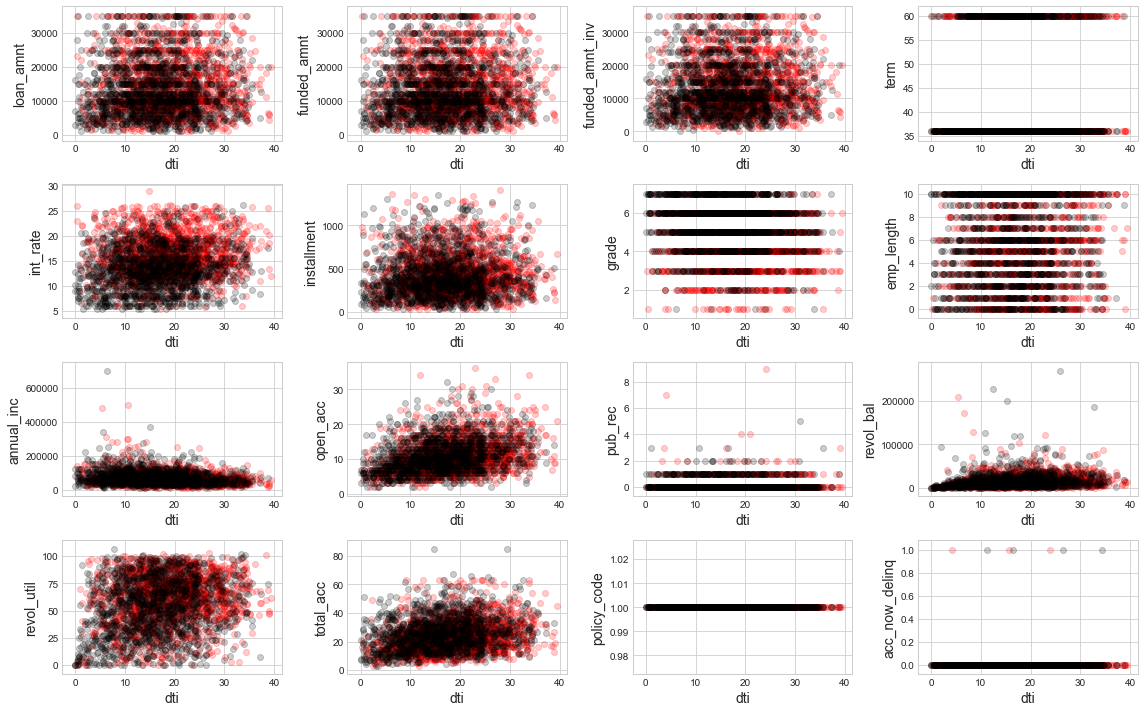

In [17]:
# for most features plotted against debt-to-income, there is little distinct separation between classes as we vary the 
# feature values. (dti should be a major risk factor, but there is much overlap between classes)
# model performs very well for positive classes because it predicts the positive class so often

# how do we find the negative classes which seem to be intertwined in noise within the positive classes?

fig = plt.figure(figsize=(16,10))


d = 0 
k = 0
for i in range(len(numerical)):
    features = ['dti',numerical[k]]
    if features[1] == 'dti':
        k += 1
        d -= 1
        continue
    
    charged_off_sample = features_train[~targets_train.astype(bool)][features].sample(1500,random_state=2)
    fully_paid_sample = features_train[targets_train.astype(bool)][features].sample(1500,random_state=2)
    
    ax = fig.add_subplot(4,4,i+1+d)
    ax.scatter(charged_off_sample[features[0]],charged_off_sample[features[1]],facecolor='r',alpha=0.2)
    ax.scatter(fully_paid_sample[features[0]],fully_paid_sample[features[1]],facecolor='k',alpha=0.2)
    ax.set_ylabel(features[1],fontsize=14)
    ax.set_xlabel(features[0],fontsize=14)
    k += 1

plt.tight_layout()

In [18]:
# baseline score using limited features -- only those which could be known at time of loan origination
# this problem is less trivial and provides a better baseline

lr = LogisticRegression()
lr.fit(features_train[numerical],targets_train)
accuracy_score(lr.predict(features_test[numerical]),targets_test)

0.82309704006022899

In [19]:
# precision on the negative cases is fairly bad on both the training and test sets
# recall is very good on the positive cases on both the training and test sets

# seems the model is very good at correctly predicting positive cases, but is excessively likely to predict inputs as positive
# (this is evident by the relatively lower precision)

print('TRAIN'+classification_report(targets_train,lr.predict(features_train[numerical])))
print('TEST'+classification_report(targets_test,lr.predict(features_test[numerical])))

# about a fifth of the training data (17.7%) and a tenth (11.7%) of the test data represent negative classes, but the
# classifier outputs negative predictions only about .08% of the time on the test data. the binary imbalance seems to be
# making the model insensitive to negative cases. 

print('test set negative class predictions: '+str((lr.predict(features_test[numerical])-1).sum()*-1))
print('test set positive class predictions: '+str((lr.predict(features_test[numerical])).sum()))

TRAIN             precision    recall  f1-score   support

          0       0.43      0.00      0.00     35780
          1       0.82      1.00      0.90    166114

avg / total       0.75      0.82      0.74    201894

TEST             precision    recall  f1-score   support

          0       0.50      0.00      0.00      8929
          1       0.82      1.00      0.90     41545

avg / total       0.77      0.82      0.74     50474

negative class predictions: 4
positive class predictions: 50470


In [20]:
# the negative class represents 17.7% of the training set and 11.5% of the test set
# yet, the model outputs the negative class < 1% of the time

print(((targets_train-1).sum()*-1)/(targets_train.sum()+((targets_train-1).sum()*-1)))
print(((targets_test-1).sum()*-1)/(targets_test.sum()+((targets_train-1).sum()*-1)))
print(((lr.predict(features_test[numerical])-1).sum()*-1)/\
      ((lr.predict(features_test[numerical])).sum()+((lr.predict(features_test[numerical])-1).sum()*-1)))

0.17722171040248844
0.11547365017782088
7.92487221144e-05


In [21]:
# the true negative rate is extremely low. however, the model's precision on negative cases is a lot higher (50%)
# it seems the model very rarely outputs negative cases..yet when it does, it's still only correct half of the time

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(targets_train,lr.predict(features_train[numerical])).ravel()
TNR = tn/len(targets_train[targets_train==0])
TNR

0.00036333147009502513

---
## Other Models' Baseline Performance (no hyperparameter optimization - defaults used)

In [22]:
# Gaussian Naive Bayes has a slightly lower accuracy

from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(features_train[numerical],targets_train)
print(accuracy_score(GNB.predict(features_test[numerical]),targets_test))
print('\n')

# the recall on negative classes with Gaussian NB is significantly better than with Logistic Regression

print('TRAIN'+classification_report(targets_train,GNB.predict(features_train[numerical])))
print('TEST'+classification_report(targets_test,GNB.predict(features_test[numerical])))

# Gaussian NB seems much more sensitive to negative class predictions. it performs better than Logistic Regression, but
# there is still much room for improvement in recall of the negative class

print('test set negative class predictions: '+str((GNB.predict(features_test[numerical])-1).sum()*-1))
print('test set positive class predictions: '+str((GNB.predict(features_test[numerical])).sum()))

# Gaussian NB seems to have the best recall. flag datapoints using Gaussian NB and input into another model for the final
# prediction? apply predictive ML algorithms in a pipeline this way--ensemble method in series rather than in parallel

0.764789792765


TRAIN             precision    recall  f1-score   support

          0       0.33      0.31      0.32     35780
          1       0.85      0.87      0.86    166114

avg / total       0.76      0.77      0.76    201894

TEST             precision    recall  f1-score   support

          0       0.33      0.31      0.32      8929
          1       0.85      0.86      0.86     41545

avg / total       0.76      0.76      0.76     50474

negative class predictions: 8443
positive class predictions: 42031


In [23]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier()
kNN.fit(features_train[numerical],targets_train)
print(accuracy_score(kNN.predict(features_test[numerical]),targets_test))
print('\n')

# the recall on negative classes with kNN is in between Logistic Regression and Gaussian NB

print('TRAIN'+classification_report(targets_train,kNN.predict(features_train[numerical])))
print('TEST'+classification_report(targets_test,kNN.predict(features_test[numerical])))

# kNN has very good recall on positive classes.. perhaps an ensemble method will provide the best result
# between recall and precision of both classes

print('test set negative class predictions: '+str((kNN.predict(features_test[numerical])-1).sum()*-1))
print('test set positive class predictions: '+str((kNN.predict(features_test[numerical])).sum()))

0.793695764156


TRAIN             precision    recall  f1-score   support

          0       0.63      0.19      0.29     35780
          1       0.85      0.98      0.91    166114

avg / total       0.81      0.84      0.80    201894

TEST             precision    recall  f1-score   support

          0       0.23      0.07      0.11      8929
          1       0.83      0.95      0.88     41545

avg / total       0.72      0.79      0.75     50474

negative class predictions: 2742
positive class predictions: 47732


In [24]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier().fit(features_train[numerical],targets_train)
print(accuracy_score(RF.predict(features_test[numerical]),targets_test))
print('\n')

# Random Forest has very good overall performance on the training set, but much worse performance on the test set
# (overfitted..? tuning hyperparameters should help performance on test set)


print('TRAIN'+classification_report(targets_train,RF.predict(features_train[numerical])))
print('TEST'+classification_report(targets_test,RF.predict(features_test[numerical])))

# sensitivity to negative class predictions seem somewhere between Gaussian NB and kNN

print('test set negative class predictions: '+str((RF.predict(features_test[numerical])-1).sum()*-1))
print('test set positive class predictions: '+str((RF.predict(features_test[numerical])).sum()))

0.795696794389


TRAIN             precision    recall  f1-score   support

          0       0.99      0.96      0.98     35780
          1       0.99      1.00      1.00    166114

avg / total       0.99      0.99      0.99    201894

TEST             precision    recall  f1-score   support

          0       0.33      0.15      0.21      8929
          1       0.84      0.93      0.88     41545

avg / total       0.75      0.80      0.76     50474

negative class predictions: 4077
positive class predictions: 46397


In [25]:
# conclusion: the LR model first appears to perform well (good accuracy) because there are an excessive number of positive cases
# in the data set. the model outputs positive predictions often and does it well, but misses almost all of the negative cases
# the model is insensitive to the negative class because the negative class has many feature values similar to the positive
# class, making them very difficult for the model to detect. 

# other ML models offer a much better balance, with significantly better recall on the negative class for slight reductions
# in accuracy

# it seems the next step is to make the model more sensitive to negative class predictions. this will likely come at the cost of
# reduction in recall for the positive class. the goal will be to increase negative class precision/recall without excessive
# reduction of precision/recall of the positive class

---